In [1]:
# Cell 1: Install Required Dependencies with Version Constraints
!pip install "numpy<2.0" --upgrade
!pip install openai transformers scikit-learn ast2json pytest coverage pytest-cov pandas matplotlib seaborn tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: numpy<2.0 in ./venv/lib/python3.9/site-packages (1.26.4)
You should consider upgrading via the '/Users/sepehr/IdeaProjects/testgen-council/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sepehr/IdeaProjects/testgen-council/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sepehr/IdeaProjects/testgen-council/venv/bin/python3 -m pip install --upgrade pip' command.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/bin/jupyter-nbextension", line 8, in <module>
    sys.exit(main())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jupyter_core/application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/traitlets/config/application.py", l

In [2]:
# Cell 2: Import Required Libraries with Error Handling
import ast
import json
import os
import re
import subprocess
import tempfile
from typing import List, Dict, Tuple, Any
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Core data science imports
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
except ImportError as e:
    print(f"NumPy import error: {e}")

try:
    import pandas as pd
    print(f"Pandas version: {pd.__version__}")
except ImportError as e:
    print(f"Pandas import error: {e}")

# ML and NLP imports
try:
    from sklearn.metrics.pairwise import cosine_similarity
    print("Scikit-learn imported successfully")
except ImportError as e:
    print(f"Scikit-learn import error: {e}")

# OpenAI import
try:
    import openai
    print(f"OpenAI library version: {openai.__version__}")
except ImportError as e:
    print(f"OpenAI import error: {e}")

# Plotting imports
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.rcParams['figure.figsize'] = (12, 8)
    sns.set_style("whitegrid")
    print("Plotting libraries imported successfully")
except ImportError as e:
    print(f"Plotting libraries import error: {e}")

# Progress bar
try:
    from tqdm import tqdm
    print("tqdm imported successfully")
except ImportError as e:
    print(f"tqdm import error: {e}")

print("All imports completed!")

NumPy version: 1.26.4
Pandas version: 2.3.2
Scikit-learn imported successfully
OpenAI library version: 1.108.1
Plotting libraries imported successfully
tqdm imported successfully
All imports completed!


In [3]:
# Cell 3: Configuration and API Setup
SYNTHESIZER_MODEL = "gemini-2.0-flash"

class Config:
    """Configuration class for the intelligent council system"""
    
    # API Keys (replace with your actual keys)
    OPENAI_API_KEY = "sk-JdU36bC7BG2996XHH3YmKOQG8Xm9x9ii5u5E9uwPC54oAkHE"
    
    # Base URLs for different providers
    OPENAI_BASE_URL = "https://api.gapgpt.app/v1"  # Default OpenAI

    
    # Model configurations
    LLM_MODELS = {
        "gemini-2.0-flash": {
            "type": "openai",
            "model_name": "gemini-2.0-flash",
            "base_url": OPENAI_BASE_URL,
            "api_key": OPENAI_API_KEY,
        },
        "gpt-5-mini": {
            "type": "openai", 
            "model_name": "gpt-5-mini",
            "base_url": OPENAI_BASE_URL,
            "api_key": OPENAI_API_KEY,
        },
        "grok-3-mini": {
            "type": "openai",
            "model_name": "grok-3-mini",
            "base_url": OPENAI_BASE_URL,
            "api_key": OPENAI_API_KEY,
        }
    }
    
    # Test categories
    TEST_CATEGORIES = [
        "positive",    # مثبت - حالات عادی
        "negative",    # منفی - حالات خطا
        "boundary",    # مرزی - مقادیر حدی
        "edge_case",   # موارد استثنایی
        "security"     # امنیتی
    ]

# Initialize configuration
config = Config()

# Setup API clients
if config.OPENAI_API_KEY != "sk-JdU36bC7BG2996XHH3YmKOQG8Xm9x9ii5u5E9uwPC54oAkHE":
    openai.api_key = config.OPENAI_API_KEY

In [4]:
# Cell 4: Code Analysis and AST Processing Module
class CodeAnalyzer:
    """Analyzes Python code and extracts function information using AST"""
    
    @staticmethod
    def extract_function_info(code: str) -> Dict[str, Any]:
        """Extract function information from Python code"""
        try:
            # Clean up the code string and ensure proper formatting
            code = code.strip()
            
            # Try to parse with ast
            tree = ast.parse(code)
            functions = []
            
            for node in ast.walk(tree):
                if isinstance(node, ast.FunctionDef):
                    # Get function source by reconstructing from lines
                    lines = code.split('\n')
                    start_line = node.lineno - 1
                    end_line = node.end_lineno if hasattr(node, 'end_lineno') else len(lines)
                    
                    func_source = '\n'.join(lines[start_line:end_line])
                    
                    func_info = {
                        'name': node.name,
                        'args': [arg.arg for arg in node.args.args],
                        'docstring': ast.get_docstring(node),
                        'source_code': func_source,
                        'line_start': node.lineno,
                        'line_end': node.end_lineno if hasattr(node, 'end_lineno') else len(lines)
                    }
                    functions.append(func_info)
            
            return {
                'functions': functions,
                'total_functions': len(functions),
                'source_code': code
            }
            
        except SyntaxError as e:
            print(f"Syntax error parsing code: {e}")
            print(f"Error at line {e.lineno}: {e.text}")
            print(f"Code that failed to parse:\n{code}")
            return {'functions': [], 'total_functions': 0, 'source_code': code, 'syntax_error': str(e)}
        except Exception as e:
            print(f"Error parsing code: {e}")
            return {'functions': [], 'total_functions': 0, 'source_code': code, 'error': str(e)}
    
    @staticmethod
    def extract_test_methods_from_response(response: str) -> List[Dict[str, str]]:
        """Extract individual test methods from LLM response"""
        test_methods = []
        
        # Try to find test functions using regex
        test_pattern = r'def (test_\w+)\([^)]*\):(.*?)(?=def test_|\Z)'
        matches = re.findall(test_pattern, response, re.DOTALL)
        
        for match in matches:
            func_name, func_body = match
            full_test = f"def {func_name}():{func_body}"
            test_methods.append({
                'name': func_name,
                'code': full_test.strip()
            })
        
        return test_methods

# Initialize code analyzer
code_analyzer = CodeAnalyzer()

In [5]:
# Cell 5: LLM Council Module
class LLMCouncil:
    """Manages multiple LLM models for test case generation"""
    
    def __init__(self, config: Config):
        self.config = config
        self.models = config.LLM_MODELS
        self.client = openai.OpenAI(
            base_url = config.OPENAI_BASE_URL,
            api_key = config.OPENAI_API_KEY
        )
        
    def create_test_generation_prompt(self, function_info: Dict[str, Any]) -> str:
        """Create an optimized prompt for test case generation"""
        func = function_info['functions'][0] if function_info['functions'] else {}
        
        prompt = f"""
You are an expert Python test engineer. Generate comprehensive unit tests for the following function.

FUNCTION TO TEST:
```python
{func.get('source_code', function_info['source_code'])}
```

REQUIREMENTS:
1. Generate diverse test cases covering:
   - Normal/positive cases (typical usage)
   - Edge cases and boundary values
   - Negative cases (invalid inputs)
   - Error handling scenarios
   - Security considerations if applicable

2. For each test, specify its category using comments:
   - # Category: positive
   - # Category: negative  
   - # Category: boundary
   - # Category: edge_case
   - # Category: security

3. Use pytest format with clear, descriptive test names
4. Include assertions with meaningful error messages
5. Test both expected outputs and error conditions

Generate 5-10 well-documented test cases. Focus on quality and coverage over quantity.

EXAMPLE FORMAT:

```python
import pytest

def test_function_name_positive_case():
    '''Test normal functionality with valid inputs'''
    # Category: positive
    result = function_name(valid_input)
    assert result == expected_output, "Should handle normal case correctly"

def test_function_name_boundary_case():
    '''Test boundary conditions'''
    # Category: boundary
    # Test implementation here
```

Generate the tests now:
"""
        return prompt

    def call_openai_model(self, prompt: str, model_config: Dict) -> str:
        """Call OpenAI API"""
        try:
            response = self.client.chat.completions.create(
                model=model_config["model_name"],
                messages=[{"role": "user", "content": prompt}]
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error calling OpenAI API: {e}")
            return ""

    def generate_tests_from_council(self, function_info: Dict[str, Any]) -> Dict[str, Any]:
        """Generate test cases using all models in the council"""
        prompt = self.create_test_generation_prompt(function_info)
        council_results = {}

        print("🤖 Consulting LLM Council for test generation...")

        for model_name, model_config in tqdm(self.models.items(), desc="Generating tests"):
            try:
                if model_config["type"] == "openai":
                    response = self.call_openai_model(prompt, model_config)
                else:
                    response = ""

                # Extract test methods from response
                test_methods = code_analyzer.extract_test_methods_from_response(response)

                council_results[model_name] = {
                    'raw_response': response,
                    'test_methods': test_methods,
                    'test_count': len(test_methods)
                }

                print(f"✅ {model_name}: Generated {len(test_methods)} test cases")

            except Exception as e:
                print(f"❌ Error with {model_name}: {e}")
                council_results[model_name] = {
                    'raw_response': "",
                    'test_methods': [],
                    'test_count': 0
                }

        return council_results

# Initialize LLM Council
llm_council = LLMCouncil(config)

In [6]:
# Cell 6: Test Classification Module
class TestClassifier:
    """Classifies test cases by category"""
    
    @staticmethod
    def extract_category_from_test(test_code: str) -> str:
        """Extract category from test code comments"""
        category_pattern = r'#\s*Category:\s*(\w+)'
        match = re.search(category_pattern, test_code, re.IGNORECASE)
        
        if match:
            category = match.group(1).lower()
            if category in config.TEST_CATEGORIES:
                return category
        
        # Fallback classification based on test name and content
        test_code_lower = test_code.lower()
        
        if 'error' in test_code_lower or 'exception' in test_code_lower or 'invalid' in test_code_lower:
            return 'negative'
        elif 'boundary' in test_code_lower or 'edge' in test_code_lower or 'limit' in test_code_lower:
            return 'boundary'
        elif 'security' in test_code_lower or 'auth' in test_code_lower:
            return 'security'
        else:
            return 'positive'
    
    @staticmethod
    def classify_council_results(council_results: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Classify all test cases from council results"""
        all_classified_tests = []
        
        for model_name, results in council_results.items():
            for test in results['test_methods']:
                category = TestClassifier.extract_category_from_test(test['code'])
                classified_test = test.copy()
                classified_test['category'] = category
                classified_test['source_model'] = model_name
                all_classified_tests.append(classified_test)
        
        return all_classified_tests

# Initialize classifier
test_classifier = TestClassifier()

In [7]:
# Cell 7: Enhanced Test Synthesizer Module (UPDATED)
class TestSynthesizer:
    """Synthesizes final optimized test file with intelligent duplicate removal"""
    
    def __init__(self, llm_council: LLMCouncil):
        self.llm_council = llm_council
    
    def create_synthesis_prompt(self, all_tests: List[Dict], function_info: Dict) -> str:
        """Create prompt for synthesizing final test file with duplicate removal"""
        func = function_info['functions'][0] if function_info['functions'] else {}
        
        # Group tests by model for better presentation
        tests_by_model = {}
        for test in all_tests:
            model = test['source_model']
            if model not in tests_by_model:
                tests_by_model[model] = []
            tests_by_model[model].append(test)
        
        # Create formatted test presentation
        test_presentation = ""
        for model, tests in tests_by_model.items():
            test_presentation += f"\n--- Tests from {model} ---\n"
            for i, test in enumerate(tests, 1):
                test_presentation += f"\nTest {i} (Category: {test['category']}):\n"
                test_presentation += f"```python\n{test['code']}\n```\n"
        
        function_name = func.get('name', 'unknown_function')
        
        prompt = f"""
You are an expert Python test engineer responsible for creating the final, optimized test suite.

ORIGINAL FUNCTION TO TEST:
```python
{func.get('source_code', function_info['source_code'])}
```

RAW TESTS FROM MULTIPLE AI MODELS:
{test_presentation}

YOUR TASK:
1. **DO NOT INCLUDE THE SOURCE FUNCTION**: The function will be saved separately in function.py and imported.

2. **USE IMPORTS**: Start your test file with: from function import {function_name}

3. **ANALYZE ALL TESTS**: Carefully examine each test case for:
   - Functionality being tested
   - Input/output scenarios
   - Edge cases covered
   - Error conditions tested

4. **REMOVE DUPLICATES**: Identify and eliminate tests that are functionally equivalent, even if they have different:
   - Variable names
   - Assertion styles
   - Code structure
   - Comments

5. **SELECT BEST REPRESENTATIVES**: When multiple tests cover the same scenario:
   - Choose the most comprehensive version
   - Prefer tests with better error messages
   - Keep tests with clearer documentation

6. **ENSURE COMPREHENSIVE COVERAGE**: Make sure the final suite covers:
   - All major functionality paths
   - Various input types and ranges
   - Error conditions and edge cases
   - All important test categories (positive, negative, boundary, edge_case, security)

7. **CREATE CLEAN, PRODUCTION-READY CODE**: Generate a single, well-organized test file with:
   - Proper imports (pytest, and function import)
   - Clear test organization by category
   - Descriptive test names and docstrings
   - Comprehensive comments
   - Consistent code style

8. **OPTIMIZE FOR QUALITY**: Prioritize test quality over quantity. Include only meaningful, non-redundant tests.

REQUIREMENTS:
- Start with: import pytest
- Then add: from function import {function_name}
- Use pytest format for all tests
- Group tests logically by category
- Ensure each test has a clear purpose
- Make test names descriptive and consistent
- DO NOT include the original function code
- DO NOT use markdown code fences (```python) in the output - provide clean Python code only

EXAMPLE OUTPUT FORMAT:

import pytest
from function import {function_name}

def test_{function_name}_positive_case():
    '''Test normal functionality with valid inputs'''
    # Category: positive
    result = {function_name}(valid_input)
    assert result == expected_output, "Should handle normal case correctly"

def test_{function_name}_boundary_case():
    '''Test boundary conditions'''
    # Category: boundary
    # Test implementation here

Generate the complete, final test file that represents the best, non-duplicate tests from all models:
"""
        return prompt
    
    def synthesize_final_test_file(self, all_tests: List[Dict], function_info: Dict) -> Dict[str, Any]:
        """Synthesize the final optimized test file with duplicate removal"""
        print("🔄 Synthesizing final test file with intelligent duplicate removal...")
        
        prompt = self.create_synthesis_prompt(all_tests, function_info)
        
        # Use the best available model for synthesis
        best_model = SYNTHESIZER_MODEL if SYNTHESIZER_MODEL in self.llm_council.models else list(self.llm_council.models.keys())[0]
        model_config = self.llm_council.models[best_model]
        
        try:
            if model_config["type"] == "openai":
                synthesized_content = self.llm_council.call_openai_model(prompt, model_config)
                
                # Clean the synthesized content immediately
                cleaned_content = self._clean_synthesized_content(synthesized_content)
                
                # Extract final tests from synthesized content
                final_tests = self._extract_final_tests_from_synthesis(cleaned_content, all_tests)
                
                print(f"✅ Final test file synthesized successfully!")
                print(f"📊 Reduced {len(all_tests)} original tests to {len(final_tests)} unique tests")
                print(f"📉 Reduction ratio: {((len(all_tests) - len(final_tests)) / len(all_tests)) * 100:.1f}%")
                
                return {
                    'synthesized_content': cleaned_content,
                    'final_tests': final_tests,
                    'original_count': len(all_tests),
                    'final_count': len(final_tests),
                    'reduction_ratio': (len(all_tests) - len(final_tests)) / len(all_tests) if len(all_tests) > 0 else 0,
                    'synthesizer_model': best_model
                }
            else:
                return self._fallback_synthesis(all_tests, function_info)
                
        except Exception as e:
            print(f"❌ Error in synthesis, using fallback: {e}")
            return self._fallback_synthesis(all_tests, function_info)
    
    def _clean_synthesized_content(self, content: str) -> str:
        """Clean synthesized content by removing markdown artifacts"""
        lines = content.split('\n')
        cleaned_lines = []
        
        for line in lines:
            stripped_line = line.strip()
            
            # Skip markdown code fence lines
            if stripped_line in ['```python', '```py', '```', '```\n']:
                continue
            
            # Remove leading ```python or ```py from lines that start with it
            if stripped_line.startswith('```python'):
                line = line.replace('```python', '', 1)
            elif stripped_line.startswith('```py'):
                line = line.replace('```py', '', 1)
            elif stripped_line.startswith('```') and stripped_line.endswith('```'):
                # Skip lines that are just code fences
                continue
            
            cleaned_lines.append(line)
        
        # Join back and clean up any extra newlines at start/end
        cleaned_code = '\n'.join(cleaned_lines).strip()
        
        # Remove any remaining triple backticks that might be at the end
        while cleaned_code.endswith('```'):
            cleaned_code = cleaned_code[:-3].strip()
        
        return cleaned_code
    
    def _extract_final_tests_from_synthesis(self, synthesized_content: str, original_tests: List[Dict]) -> List[Dict]:
        """Extract final test information from synthesized content"""
        final_tests = []
        
        # Extract test methods from synthesized content
        test_methods = code_analyzer.extract_test_methods_from_response(synthesized_content)
        
        for test_method in test_methods:
            # Classify the synthesized test
            category = test_classifier.extract_category_from_test(test_method['code'])
            
            final_test = {
                'name': test_method['name'],
                'code': test_method['code'],
                'category': category,
                'source': 'synthesized',
                'original_sources': self._find_original_sources(test_method, original_tests)
            }
            final_tests.append(final_test)
        
        return final_tests
    
    def _find_original_sources(self, synthesized_test: Dict, original_tests: List[Dict]) -> List[str]:
        """Find which original tests likely contributed to the synthesized test"""
        sources = []
        synthesized_name = synthesized_test['name'].lower()
        
        for original in original_tests:
            original_name = original['name'].lower()
            # Simple heuristic: if names are similar or test same functionality
            if (synthesized_name in original_name or original_name in synthesized_name or
                any(word in original_name for word in synthesized_name.split('_') if len(word) > 3)):
                sources.append(original['source_model'])
        
        return list(set(sources))  # Remove duplicates
    
    def _fallback_synthesis(self, all_tests: List[Dict], function_info: Dict) -> Dict[str, Any]:
        """Fallback synthesis method using simple deduplication"""
        func = function_info['functions'][0] if function_info['functions'] else {}
        function_name = func.get('name', 'unknown_function')
        
        # Simple deduplication based on test names and categories
        seen_tests = set()
        unique_tests = []
        
        for test in all_tests:
            test_signature = (test['name'].lower(), test['category'])
            if test_signature not in seen_tests:
                seen_tests.add(test_signature)
                unique_tests.append(test)
        
        header = f'''"""
Comprehensive Test Suite
Generated by Intelligent LLM Council
Target Function: {function_name}
Total Unique Tests: {len(unique_tests)}
Original Tests: {len(all_tests)}
Reduction Ratio: {((len(all_tests) - len(unique_tests)) / len(all_tests)) * 100:.1f}%
"""

import pytest
from function import {function_name}

'''
        
        # Group tests by category
        by_category = {}
        for test in unique_tests:
            category = test['category']
            if category not in by_category:
                by_category[category] = []
            by_category[category].append(test)
        
        # Generate organized test code
        test_code = header
        
        for category, tests in by_category.items():
            test_code += f"\n\n# {category.upper()} TESTS\n"
            test_code += f"# {'='*50}\n\n"
            
            for test in tests:
                # Remove any function definition from test code since we're importing
                test_lines = test['code'].split('\n')
                cleaned_test_lines = []
                for line in test_lines:
                    if line.strip().startswith('def ') and not line.strip().startswith('def test_'):
                        continue  # Skip function definitions that aren't tests
                    cleaned_test_lines.append(line)
                
                test_code += '\n'.join(cleaned_test_lines) + "\n\n"
        
        return {
            'synthesized_content': test_code,
            'final_tests': unique_tests,
            'original_count': len(all_tests),
            'final_count': len(unique_tests),
            'reduction_ratio': (len(all_tests) - len(unique_tests)) / len(all_tests) if len(all_tests) > 0 else 0,
            'synthesizer_model': 'fallback'
        }

# Initialize synthesizer
test_synthesizer = TestSynthesizer(llm_council)

In [8]:
# Cell 8: Coverage Analyzer
import subprocess
import re
import os
from typing import Dict, Any

class CoverageAnalyzer:
    """Analyzes code coverage for generated test files"""
    
    @staticmethod
    def _clean_terminal_output(output: str) -> str:
        """Remove terminal formatting and escape sequences"""
        # Remove ANSI escape sequences
        ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
        cleaned = ansi_escape.sub('', output)
        
        # Remove carriage returns and normalize line endings
        cleaned = cleaned.replace('\r\n', '\n').replace('\r', '\n')
        
        # Remove any remaining control characters
        cleaned = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', cleaned)
        
        return cleaned
    
    @staticmethod
    def _extract_function_coverage_percentage(stdout: str) -> float:
        """Extract coverage percentage specifically for function.py from pytest output"""
        try:
            # Clean terminal formatting first
            cleaned_stdout = CoverageAnalyzer._clean_terminal_output(stdout)
            
            # More robust regex pattern to find function.py coverage line
            # Pattern matches: function.py followed by whitespace, numbers, whitespace, percentage
            pattern = r'function\.py\s+\d+\s+\d+\s+(\d+)%'
            match = re.search(pattern, cleaned_stdout)
            
            if match:
                percentage = float(match.group(1))
                print(f"Debug: Found function.py coverage: {percentage}%")
                return percentage
            
            # Fallback: Look for function.py line manually
            lines = cleaned_stdout.split('\n')
            for line in lines:
                if 'function.py' in line and '%' in line:
                    print(f"Debug: Processing line: {repr(line)}")
                    
                    # Use regex to extract percentage from this specific line
                    percent_match = re.search(r'(\d+)%', line)
                    if percent_match:
                        percentage = float(percent_match.group(1))
                        print(f"Debug: Extracted percentage: {percentage}%")
                        return percentage
                    
                    # Alternative parsing if regex fails
                    parts = line.split()
                    print(f"Debug: Line parts: {parts}")
                    for part in parts:
                        if part.endswith('%'):
                            try:
                                percentage_str = part.rstrip('%')
                                percentage = float(percentage_str)
                                print(f"Debug: Parsed percentage from part '{part}': {percentage}%")
                                return percentage
                            except ValueError:
                                continue
            
            # If function.py not found specifically, return 0
            print("Warning: function.py coverage not found in output")
            print(f"Debug: Cleaned stdout:\n{cleaned_stdout}")
            return 0.0
            
        except Exception as e:
            print(f"Warning: Could not extract function.py coverage percentage: {e}")
            print(f"Debug: Raw stdout:\n{stdout}")
            return 0.0
    
    @staticmethod
    def _extract_test_execution_stats(stdout: str) -> Dict[str, int]:
        """Extract test execution statistics from pytest output"""
        try:
            cleaned_stdout = CoverageAnalyzer._clean_terminal_output(stdout)
            
            stats = {
                'total_tests': 0,
                'passed_tests': 0,
                'failed_tests': 0,
                'skipped_tests': 0,
                'error_tests': 0
            }
            
            # Look for test collection line: "collected X items"
            collection_match = re.search(r'collected (\d+) items?', cleaned_stdout)
            if collection_match:
                stats['total_tests'] = int(collection_match.group(1))
                print(f"Debug: Found total tests: {stats['total_tests']}")
            
            # Look for final result line: "X passed, Y failed, Z skipped in N.NNs"
            # Various patterns to catch different pytest output formats
            result_patterns = [
                r'(\d+) passed.*?in \d+\.\d+s',  # X passed in N.NNs
                r'(\d+) passed, (\d+) failed.*?in \d+\.\d+s',  # X passed, Y failed in N.NNs
                r'(\d+) passed, (\d+) skipped.*?in \d+\.\d+s',  # X passed, Y skipped in N.NNs
                r'(\d+) failed.*?in \d+\.\d+s',  # X failed in N.NNs
                r'(\d+) skipped.*?in \d+\.\d+s',  # X skipped in N.NNs
            ]
            
            # Try the comprehensive pattern first
            comprehensive_pattern = r'(?:(\d+) failed.*?)?(?:(\d+) passed.*?)?(?:(\d+) skipped.*?)?(?:(\d+) error.*?)?in \d+\.\d+s'
            match = re.search(comprehensive_pattern, cleaned_stdout)
            
            if match:
                failed, passed, skipped, errors = match.groups()
                if passed:
                    stats['passed_tests'] = int(passed)
                if failed:
                    stats['failed_tests'] = int(failed)
                if skipped:
                    stats['skipped_tests'] = int(skipped)
                if errors:
                    stats['error_tests'] = int(errors)
                    
                print(f"Debug: Extracted test stats - Passed: {stats['passed_tests']}, Failed: {stats['failed_tests']}, Skipped: {stats['skipped_tests']}")
            else:
                # Fallback: look for simpler patterns
                passed_match = re.search(r'(\d+) passed', cleaned_stdout)
                if passed_match:
                    stats['passed_tests'] = int(passed_match.group(1))
                    
                failed_match = re.search(r'(\d+) failed', cleaned_stdout)
                if failed_match:
                    stats['failed_tests'] = int(failed_match.group(1))
                    
                skipped_match = re.search(r'(\d+) skipped', cleaned_stdout)
                if skipped_match:
                    stats['skipped_tests'] = int(skipped_match.group(1))
                    
                print(f"Debug: Fallback extraction - Passed: {stats['passed_tests']}, Failed: {stats['failed_tests']}")
            
            # If we couldn't get total from collection, calculate from individual counts
            if stats['total_tests'] == 0:
                stats['total_tests'] = stats['passed_tests'] + stats['failed_tests'] + stats['skipped_tests'] + stats['error_tests']
            
            return stats
            
        except Exception as e:
            print(f"Warning: Could not extract test execution stats: {e}")
            return {
                'total_tests': 0,
                'passed_tests': 0,
                'failed_tests': 0,
                'skipped_tests': 0,
                'error_tests': 0
            }
    
    @staticmethod
    def _clean_test_code(code: str) -> str:
        """Clean test code by removing markdown formatting and extra whitespace"""
        # Remove markdown code block markers
        code = re.sub(r'```python\s*\n?', '', code)
        code = re.sub(r'```\s*$', '', code)
        
        # Remove leading/trailing whitespace from each line and rejoin
        lines = [line.rstrip() for line in code.split('\n')]
        cleaned_code = '\n'.join(lines).strip()
        
        return cleaned_code
    
    @staticmethod
    def analyze_coverage(function_code: str, test_code: str) -> Dict[str, Any]:
        """
        Analyze code coverage by running the test against the function
        
        Returns:
            Dict containing coverage information and analysis
        """
        import tempfile
        import shutil
        
        coverage_info = {
            'coverage_percentage': 0.0,
            'test_passed': False,
            'error_message': None,
            'stdout': '',
            'stderr': '',
            'total_tests': 0,
            'passed_tests': 0,
            'failed_tests': 0,
            'skipped_tests': 0,
            'error_tests': 0,
            'success_rate': 0.0
        }
        
        # Create temporary directory
        with tempfile.TemporaryDirectory() as temp_dir:
            try:
                # Write function code to file
                function_file = os.path.join(temp_dir, "function.py")
                with open(function_file, 'w') as f:
                    f.write(function_code)
                
                # Clean and write test code to file
                cleaned_test_code = CoverageAnalyzer._clean_test_code(test_code)
                test_file = os.path.join(temp_dir, "test_generated.py")
                with open(test_file, 'w') as f:
                    f.write(cleaned_test_code)
                
                # Change to temp directory
                original_cwd = os.getcwd()
                os.chdir(temp_dir)
                
                try:
                    # Run pytest with coverage
                    cmd = ["python", "-m", "pytest", "test_generated.py", "--cov=.", "--cov-report=term-missing", "-v"]
                    
                    result = subprocess.run(
                        cmd,
                        capture_output=True,
                        text=True,
                        timeout=30
                    )
                    
                    coverage_info['stdout'] = result.stdout
                    coverage_info['stderr'] = result.stderr
                    coverage_info['test_passed'] = result.returncode == 0
                    
                    # Extract coverage percentage for function.py
                    coverage_percentage = CoverageAnalyzer._extract_function_coverage_percentage(result.stdout)
                    coverage_info['coverage_percentage'] = coverage_percentage
                    
                    # Extract test execution statistics
                    test_stats = CoverageAnalyzer._extract_test_execution_stats(result.stdout)
                    coverage_info.update(test_stats)
                    
                    # Calculate success rate
                    if coverage_info['total_tests'] > 0:
                        coverage_info['success_rate'] = (coverage_info['passed_tests'] / coverage_info['total_tests']) * 100.0
                    else:
                        coverage_info['success_rate'] = 0.0
                    
                    print(f"Coverage analysis complete. Function.py coverage: {coverage_percentage}%")
                    print(f"Test results: {coverage_info['passed_tests']}/{coverage_info['total_tests']} passed ({coverage_info['success_rate']:.1f}%)")
                    
                finally:
                    # Restore original working directory
                    os.chdir(original_cwd)
                    
            except subprocess.TimeoutExpired:
                coverage_info['error_message'] = "Test execution timed out"
                print("Error: Test execution timed out")
            except Exception as e:
                coverage_info['error_message'] = str(e)
                print(f"Error during coverage analysis: {e}")
        
        return coverage_info


# Initialize coverage analyzer
coverage_analyzer = CoverageAnalyzer()

In [9]:
# Cell 9: Main Pipeline Orchestrator (Updated with separate function file saving)
class IntelligentTestCouncil:
    """Main orchestrator for the intelligent test generation pipeline"""
    
    def __init__(self, config: Config):
        self.config = config
        self.code_analyzer = CodeAnalyzer()
        self.llm_council = LLMCouncil(config)
        self.test_classifier = TestClassifier()
        self.test_synthesizer = TestSynthesizer(self.llm_council)
        self.coverage_analyzer = CoverageAnalyzer()
        
    def generate_comprehensive_tests(self, function_code: str) -> Dict[str, Any]:
        """Main pipeline for generating comprehensive test suite"""
        print("🚀 Starting Intelligent Test Council Pipeline")
        print("=" * 60)
        
        # Step 1: Analyze the input function
        print("\n📝 Step 1: Analyzing input function...")
        function_info = self.code_analyzer.extract_function_info(function_code)
        
        if not function_info['functions']:
            error_msg = 'No functions found in the provided code'
            if 'syntax_error' in function_info:
                error_msg += f". Syntax error: {function_info['syntax_error']}"
            return {'error': error_msg}
        
        print(f"✅ Found {function_info['total_functions']} function(s)")
        
        # Step 2: Generate tests using LLM council
        print("\n🤖 Step 2: Consulting LLM Council...")
        council_results = self.llm_council.generate_tests_from_council(function_info)
        
        # Step 3: Classify all test cases
        print("\n🏷️  Step 3: Classifying test cases...")
        all_classified_tests = self.test_classifier.classify_council_results(council_results)
        
        print(f"✅ Total tests generated: {len(all_classified_tests)}")
        
        # Display category distribution
        category_counts = Counter(test['category'] for test in all_classified_tests)
        print("📊 Category distribution:")
        for category, count in category_counts.items():
            print(f"   • {category}: {count} tests")
        
        # Step 4: Synthesize final test file with intelligent duplicate removal
        print(f"\n🔄 Step 4: Synthesizing final test file with duplicate removal...")
        synthesis_results = self.test_synthesizer.synthesize_final_test_file(all_classified_tests, function_info)
        
        # Step 5: Analyze coverage
        print("\n📊 Step 5: Analyzing code coverage...")
        coverage_results = self.coverage_analyzer.analyze_coverage(
            function_code, 
            synthesis_results['synthesized_content']
        )
        
        # Prepare comprehensive results
        results = {
            'function_info': function_info,
            'council_results': council_results,
            'all_classified_tests': all_classified_tests,
            'synthesis_results': synthesis_results,
            'final_test_file': synthesis_results['synthesized_content'],
            'coverage_results': coverage_results,
            'statistics': {
                'original_test_count': len(all_classified_tests),
                'final_test_count': synthesis_results['final_count'],
                'reduction_ratio': synthesis_results['reduction_ratio'],
                'coverage_percentage': coverage_results.get('coverage_percentage', 0.0),
                'test_success_rate': coverage_results.get('success_rate', 0.0),
                'total_tests_run': coverage_results.get('total_tests', 0),
                'passed_tests': coverage_results.get('passed_tests', 0),
                'failed_tests': coverage_results.get('failed_tests', 0),
                'skipped_tests': coverage_results.get('skipped_tests', 0),
                'error_tests': coverage_results.get('error_tests', 0),
                'models_used': list(council_results.keys()),
                'categories_found': list(category_counts.keys()),
                'synthesizer_model': synthesis_results['synthesizer_model']
            }
        }
        
        print("\n🎉 Pipeline completed successfully!")
        print(f"📊 Test Success Rate: {coverage_results.get('success_rate', 0.0):.1f}%")
        print(f"📈 Code Coverage: {coverage_results.get('coverage_percentage', 0.0):.1f}%")
        print(f"✅ Passed Tests: {coverage_results.get('passed_tests', 0)}/{coverage_results.get('total_tests', 0)}")
        print("=" * 60)
        
        return results
    
    def clean_python_code(self, code_content: str) -> str:
        """Clean Python code by removing markdown code fences and extra formatting"""
        lines = code_content.split('\n')
        cleaned_lines = []
        
        for line in lines:
            stripped_line = line.strip()
            
            # Skip markdown code fence lines
            if stripped_line in ['```python', '```py', '```']:
                continue
            
            # Remove leading ```python or ```py from lines that start with it
            if stripped_line.startswith('```python'):
                line = line.replace('```python', '', 1)
            elif stripped_line.startswith('```py'):
                line = line.replace('```py', '', 1)
            elif stripped_line.startswith('```') and stripped_line.endswith('```'):
                # Skip lines that are just code fences
                continue
            
            cleaned_lines.append(line)
        
        # Join back and clean up any extra newlines at start/end
        cleaned_code = '\n'.join(cleaned_lines).strip()
        
        # Remove any remaining triple backticks that might be at the end
        while cleaned_code.endswith('```'):
            cleaned_code = cleaned_code[:-3].strip()
        
        return cleaned_code
    
    def save_results(self, results: Dict[str, Any], output_dir: str = "./test_output"):
        """Save all results to files with separate function file"""
        os.makedirs(output_dir, exist_ok=True)

        # Get the original function code
        function_info = results['function_info']
        if function_info['functions']:
            function_code = function_info['functions'][0]['source_code']
        else:
            function_code = function_info['source_code']

        # Save the function under test to function.py
        with open(f"{output_dir}/function.py", 'w', encoding='utf-8') as f:
            f.write(function_code)

        # The test file content should already be cleaned from synthesis
        test_file_content = results['final_test_file']

        # Additional cleaning just in case
        cleaned_test_content = self.clean_python_code(test_file_content)

        # Save final test file (cleaned Python code) 
        with open(f"{output_dir}/test_generated.py", 'w', encoding='utf-8') as f:
            f.write(cleaned_test_content)

        # Save detailed results
        with open(f"{output_dir}/analysis_results.json", 'w', encoding='utf-8') as f:
            # Convert results to JSON-serializable format
            json_results = results.copy()
            # Remove non-serializable content
            if 'synthesis_results' in json_results:
                json_results['synthesis_results'] = {
                    k: v for k, v in json_results['synthesis_results'].items() 
                    if k != 'synthesized_content'  # This is already in final_test_file
                }
            json.dump(json_results, f, indent=2, ensure_ascii=False)

        print(f"📁 Results saved to {output_dir}/")
        print(f"🔧 Function under test: {output_dir}/function.py")
        print(f"✅ Clean Python test file: {output_dir}/test_generated.py")
        print(f"📊 Analysis results: {output_dir}/analysis_results.json")

# Initialize the main pipeline
intelligent_council = IntelligentTestCouncil(config)

In [10]:
# Cell 10: Example Usage and Testing (FIXED FUNCTIONS)
# Example 1: Simple mathematical function (PROPERLY INDENTED)
example_function_1 = '''def divide_numbers(a, b):
    """
    Divide two numbers with error handling

    Args:
        a (float): Numerator
        b (float): Denominator

    Returns:
        float: Result of division

    Raises:
        ValueError: If denominator is zero
        TypeError: If inputs are not numeric
    """
    if not isinstance(a, (int, float)) or not isinstance(b, (int, float)):
        raise TypeError("Both arguments must be numeric")

    if b == 0:
        raise ValueError("Cannot divide by zero")

    return a / b'''

# Example 2: More complex function (PROPERLY INDENTED)
example_function_2 = '''def validate_password(password):
    """
    Validate password strength

    Args:
        password (str): Password to validate

    Returns:
        dict: Validation results with 'valid' boolean and 'errors' list
    """
    if not isinstance(password, str):
        return {'valid': False, 'errors': ['Password must be a string']}

    errors = []

    if len(password) < 8:
        errors.append('Password must be at least 8 characters long')

    if not any(c.isupper() for c in password):
        errors.append('Password must contain at least one uppercase letter')

    if not any(c.islower() for c in password):
        errors.append('Password must contain at least one lowercase letter')

    if not any(c.isdigit() for c in password):
        errors.append('Password must contain at least one digit')

    special_chars = '!@#$%^&*(),.?":{}|<>'
    if not any(c in special_chars for c in password):
        errors.append('Password must contain at least one special character')

    return {'valid': len(errors) == 0, 'errors': errors}'''

def demonstrate_council():
    """Demonstrate the intelligent council with example functions"""
    
    print("🎯 Demonstrating Intelligent Test Council")
    print("=" * 50)
    
    # Choose example to run (you can change this)
    selected_function = example_function_1
    
    try:
        # Run the intelligent council pipeline
        results = intelligent_council.generate_comprehensive_tests(selected_function)
        
        if 'error' in results:
            print(f"❌ Error: {results['error']}")
            return results
        
        # Display key statistics
        stats = results['statistics']
        print(f"\n📊 Key Statistics:")
        print(f"   • Original tests generated: {stats['original_test_count']}")
        print(f"   • Final tests after synthesis: {stats['final_test_count']}")
        print(f"   • Reduction ratio: {stats['reduction_ratio']:.2%}")
        print(f"   • Code coverage: {stats['coverage_percentage']:.1f}%")
        print(f"   • Models used: {', '.join(stats['models_used'])}")
        print(f"   • Test categories: {', '.join(stats['categories_found'])}")
        print(f"   • Synthesizer model: {stats['synthesizer_model']}")
        
        # Save results
        intelligent_council.save_results(results)
        
        # Display final test file preview
        print(f"\n📋 Final Test File Preview:")
        print("-" * 50)
        preview_length = 1500
        if len(results['final_test_file']) > preview_length:
            print(results['final_test_file'][:preview_length] + "\n... (truncated)")
        else:
            print(results['final_test_file'])
        
        return results
        
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        return {'error': str(e)}

demo_results = demonstrate_council()

🎯 Demonstrating Intelligent Test Council
🚀 Starting Intelligent Test Council Pipeline

📝 Step 1: Analyzing input function...
✅ Found 1 function(s)

🤖 Step 2: Consulting LLM Council...
🤖 Consulting LLM Council for test generation...


Generating tests:  33%|███████████████████████████████████████▎                                                                              | 1/3 [00:05<00:11,  5.81s/it]

✅ gemini-2.0-flash: Generated 10 test cases


Generating tests:  67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 2/3 [00:27<00:14, 14.93s/it]

✅ gpt-5-mini: Generated 9 test cases


Generating tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.22s/it]

✅ grok-3-mini: Generated 7 test cases

🏷️  Step 3: Classifying test cases...
✅ Total tests generated: 26
📊 Category distribution:
   • positive: 9 tests
   • edge_case: 5 tests
   • negative: 7 tests
   • boundary: 4 tests
   • security: 1 tests

🔄 Step 4: Synthesizing final test file with duplicate removal...
🔄 Synthesizing final test file with intelligent duplicate removal...


✅ Final test file synthesized successfully!
📊 Reduced 26 original tests to 11 unique tests
📉 Reduction ratio: 57.7%

📊 Step 5: Analyzing code coverage...
Debug: Found function.py coverage: 100.0%
Debug: Found total tests: 19
Debug: Extracted test stats - Passed: 19, Failed: 0, Skipped: 0
Coverage analysis complete. Function.py coverage: 100.0%
Test results: 19/19 passed (100.0%)

🎉 Pipeline completed successfully!
📊 Test Success Rate: 100.0%
📈 Code Coverage: 100.0%
✅ Passed Tests: 19/19

📊 Key Statistics:
   • Original tests generated: 26
   • Final tests after synthesis: 11
   • Reduction ratio: 57.69%
   • Code coverage: 100.0%
   • Models used: gemini-2.0-flash, gpt-5-mini, grok-3-mini
   • Test categories: positive, edge_case, negative, boundary, security
   • Synthesizer model: gemini-2.0-flash
📁 Results saved to ./test_output/
🔧 Function under test: ./test_output/function.py
✅ Clean Python test file: ./test_output/test_generated.py
📊 Analysis results: ./test_output/analysis_resul

📈 Analyzing Council Performance


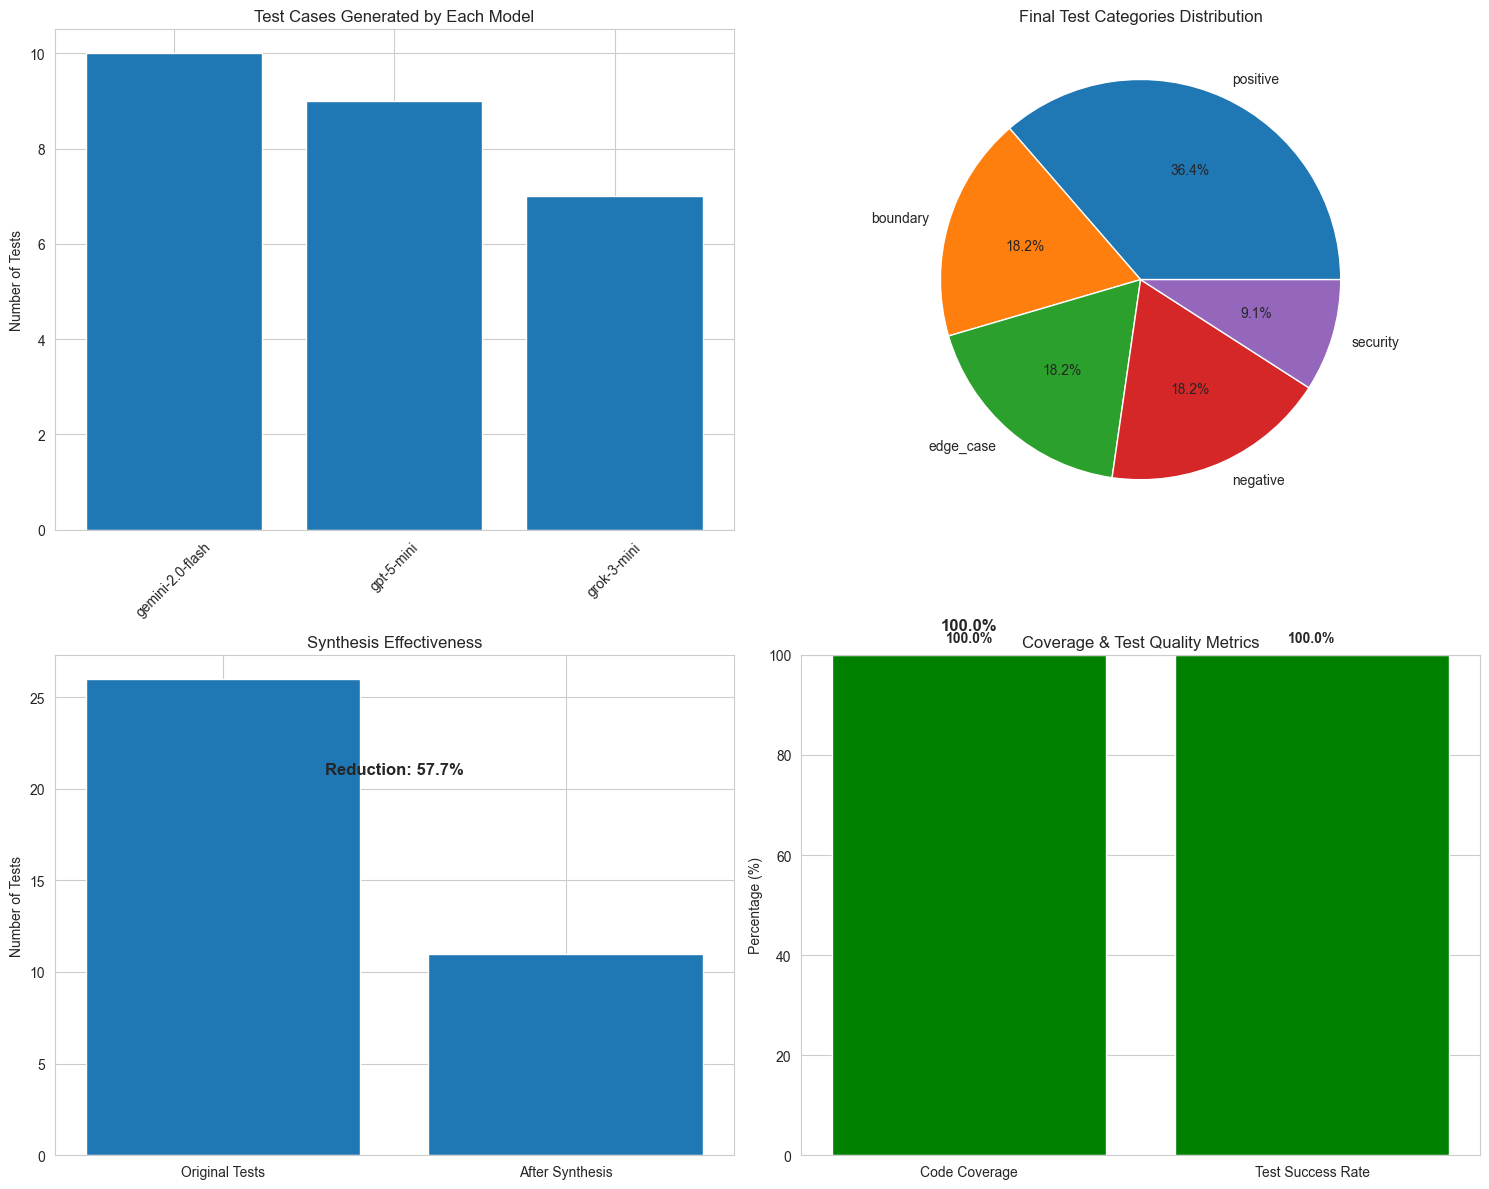

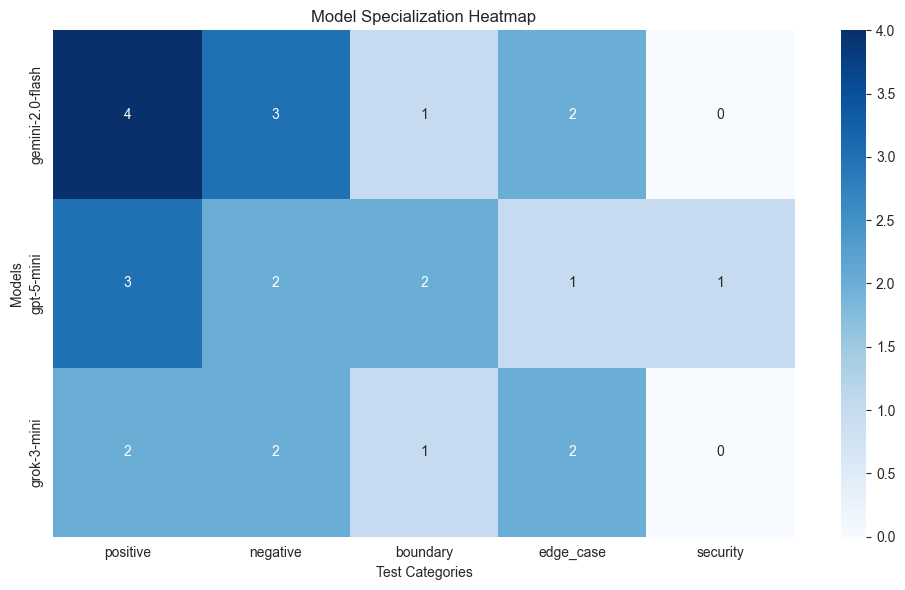

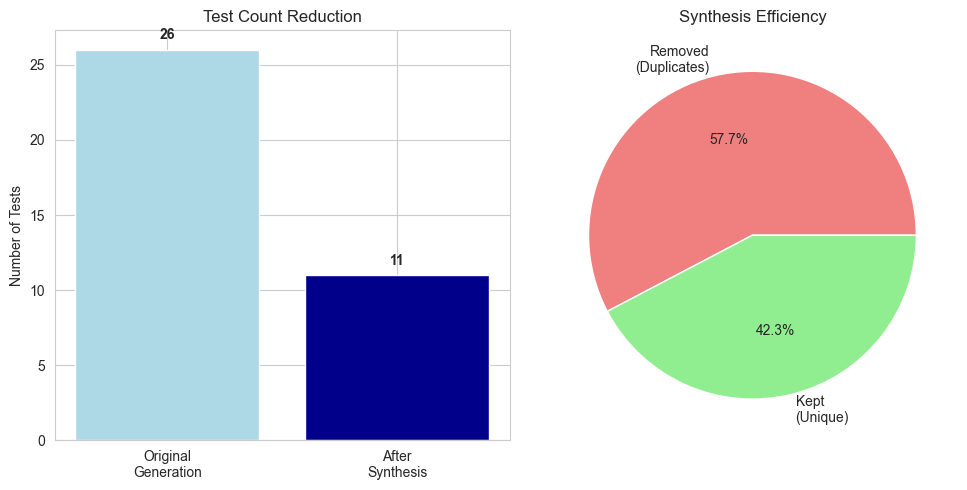

✅ Analysis complete!


In [11]:
# Cell 11: Results Analysis and Visualization
def analyze_and_visualize_results(results: Dict[str, Any]):
    """Analyze and visualize the council results"""
    
    if 'error' in results:
        print(f"Cannot analyze results due to error: {results['error']}")
        return
    
    print("📈 Analyzing Council Performance")
    print("=" * 40)
    
    # 1. Test generation and synthesis analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Model contribution
    model_counts = {}
    for model_name, model_results in results['council_results'].items():
        model_counts[model_name] = model_results['test_count']
    
    axes[0, 0].bar(model_counts.keys(), model_counts.values())
    axes[0, 0].set_title('Test Cases Generated by Each Model')
    axes[0, 0].set_ylabel('Number of Tests')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Category distribution in final tests
    if 'synthesis_results' in results and 'final_tests' in results['synthesis_results']:
        final_tests = results['synthesis_results']['final_tests']
        category_counts = {}
        for test in final_tests:
            category = test['category']
            category_counts[category] = category_counts.get(category, 0) + 1
        
        if category_counts:
            axes[0, 1].pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
            axes[0, 1].set_title('Final Test Categories Distribution')
        else:
            axes[0, 1].text(0.5, 0.5, 'No category data available', ha='center', va='center')
            axes[0, 1].set_title('Final Test Categories Distribution')
    
    # Synthesis effectiveness
    original_count = results['statistics']['original_test_count']
    final_count = results['statistics']['final_test_count']
    
    bars = axes[1, 0].bar(['Original Tests', 'After Synthesis'], [original_count, final_count])
    axes[1, 0].set_title('Synthesis Effectiveness')
    axes[1, 0].set_ylabel('Number of Tests')
    
    # Add reduction percentage as text
    reduction_pct = results['statistics']['reduction_ratio'] * 100
    axes[1, 0].text(0.5, max(original_count, final_count) * 0.8, 
                   f'Reduction: {reduction_pct:.1f}%', 
                   ha='center', fontsize=12, fontweight='bold')
    
    # Coverage visualization
    coverage_pct = results['statistics']['coverage_percentage']
    colors = ['green' if coverage_pct >= 80 else 'orange' if coverage_pct >= 60 else 'red']
    axes[1, 1].bar(['Code Coverage'], [coverage_pct], color=colors)
    axes[1, 1].set_title('Code Coverage Achieved')
    axes[1, 1].set_ylabel('Percentage (%)')
    axes[1, 1].set_ylim(0, 100)
    
    # Coverage and success rate visualization (replace the existing coverage section)
    coverage_pct = results['statistics']['coverage_percentage']
    success_rate = results['statistics']['test_success_rate']
    
    # Create a dual-metric chart
    metrics = ['Code Coverage', 'Test Success Rate']
    values = [coverage_pct, success_rate]
    colors = ['green' if v >= 80 else 'orange' if v >= 60 else 'red' for v in values]
    
    bars = axes[1, 1].bar(metrics, values, color=colors)
    axes[1, 1].set_title('Coverage & Test Quality Metrics')
    axes[1, 1].set_ylabel('Percentage (%)')
    axes[1, 1].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                       f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add coverage text
    axes[1, 1].text(0, coverage_pct + 5, f'{coverage_pct:.1f}%', 
                   ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Model collaboration analysis
    if 'all_classified_tests' in results:
        collaboration_matrix = np.zeros((len(results['council_results']), len(config.TEST_CATEGORIES)))
        model_names = list(results['council_results'].keys())
        
        for i, model_name in enumerate(model_names):
            model_tests = [test for test in results['all_classified_tests'] if test['source_model'] == model_name]
            for test in model_tests:
                category = test['category']
                if category in config.TEST_CATEGORIES:
                    j = config.TEST_CATEGORIES.index(category)
                    collaboration_matrix[i, j] += 1
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(collaboration_matrix, 
                    xticklabels=config.TEST_CATEGORIES,
                    yticklabels=model_names,
                    annot=True, 
                    cmap='Blues',
                    fmt='g')
        plt.title('Model Specialization Heatmap')
        plt.xlabel('Test Categories')
        plt.ylabel('Models')
        plt.tight_layout()
        plt.show()
    
    # 3. Synthesis quality metrics
    if 'synthesis_results' in results:
        synthesis_stats = results['synthesis_results']
        
        plt.figure(figsize=(10, 5))
        
        # Reduction effectiveness
        plt.subplot(1, 2, 1)
        stages = ['Original\nGeneration', 'After\nSynthesis']
        counts = [synthesis_stats['original_count'], synthesis_stats['final_count']]
        bars = plt.bar(stages, counts, color=['lightblue', 'darkblue'])
        plt.title('Test Count Reduction')
        plt.ylabel('Number of Tests')
        
        # Add values on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        # Reduction ratio
        plt.subplot(1, 2, 2)
        reduction_ratio = synthesis_stats['reduction_ratio']
        efficiency_score = (1 - reduction_ratio) * 100  # Remaining percentage
        
        if reduction_ratio > 0:
            wedges, texts, autotexts = plt.pie([reduction_ratio * 100, efficiency_score], 
                                             labels=['Removed\n(Duplicates)', 'Kept\n(Unique)'],
                                             autopct='%1.1f%%',
                                             colors=['lightcoral', 'lightgreen'])
        else:
            # No reduction case
            plt.pie([100], labels=['All Unique'], colors=['lightgreen'])
            
        plt.title('Synthesis Efficiency')
        
        plt.tight_layout()
        plt.show()
    
    print("✅ Analysis complete!")

# Analyze results if demonstration was successful
if 'error' not in demo_results:
    analyze_and_visualize_results(demo_results)
else:
    print("❌ Cannot analyze results due to earlier errors")

In [12]:
# Cell 12: Quality Assessment and Final Report
def generate_quality_report(results: Dict[str, Any]):
    """Generate a comprehensive quality assessment report"""
    
    if 'error' in results:
        print(f"Cannot generate quality report due to error: {results['error']}")
        return
    
    print("📋 QUALITY ASSESSMENT REPORT")
    print("=" * 50)
    
    stats = results['statistics']
    
    # 1. Test Generation Quality
    print("\n🎯 TEST GENERATION QUALITY")
    print("-" * 30)
    print(f"Models consulted: {len(stats['models_used'])}")
    print(f"Total tests generated: {stats['original_test_count']}")
    print(f"Average tests per model: {stats['original_test_count'] / len(stats['models_used']):.1f}")
    
    # 2. Synthesis Effectiveness
    print(f"\n🔄 SYNTHESIS EFFECTIVENESS")
    print("-" * 30)
    print(f"Synthesizer model: {stats['synthesizer_model']}")
    print(f"Duplicate removal ratio: {stats['reduction_ratio']:.1%}")
    print(f"Final unique tests: {stats['final_test_count']}")
    
    # Quality assessment
    if stats['reduction_ratio'] > 0.5:
        synthesis_quality = "Excellent - High duplicate detection"
    elif stats['reduction_ratio'] > 0.3:
        synthesis_quality = "Good - Moderate duplicate detection"
    elif stats['reduction_ratio'] > 0.1:
        synthesis_quality = "Fair - Some duplicate detection"
    else:
        synthesis_quality = "Low - Minimal duplicate detection"
    
    print(f"Synthesis quality: {synthesis_quality}")
    
    # 3. Coverage Analysis
    print(f"\n📊 COVERAGE ANALYSIS")
    print("-" * 30)
    coverage = stats['coverage_percentage']
    print(f"Code coverage: {coverage:.1f}%")
    
    if coverage >= 90:
        coverage_quality = "Excellent"
    elif coverage >= 80:
        coverage_quality = "Good"
    elif coverage >= 70:
        coverage_quality = "Fair"
    else:
        coverage_quality = "Needs Improvement"
    
    print(f"Coverage quality: {coverage_quality}")
    
    # 4. Test Diversity
    print(f"\n🌈 TEST DIVERSITY")
    print("-" * 30)
    categories = stats['categories_found']
    print(f"Categories covered: {len(categories)}/{len(config.TEST_CATEGORIES)}")
    print(f"Categories: {', '.join(categories)}")
    
    diversity_score = len(categories) / len(config.TEST_CATEGORIES)
    if diversity_score >= 0.8:
        diversity_quality = "Excellent"
    elif diversity_score >= 0.6:
        diversity_quality = "Good"
    elif diversity_score >= 0.4:
        diversity_quality = "Fair"
    else:
        diversity_quality = "Limited"
    
    print(f"Diversity quality: {diversity_quality}")
    
    # 5. Overall Assessment
    print(f"\n🏆 OVERALL ASSESSMENT")
    print("-" * 30)
    
    # Calculate overall score
    scores = []
    if stats['reduction_ratio'] > 0:
        scores.append(min(stats['reduction_ratio'] * 2, 1.0))  # Synthesis effectiveness
    scores.append(coverage / 100)  # Coverage score
    scores.append(diversity_score)  # Diversity score
    
    overall_score = sum(scores) / len(scores)
    
    if overall_score >= 0.8:
        overall_quality = "🌟 Excellent"
    elif overall_score >= 0.7:
        overall_quality = "👍 Good"
    elif overall_score >= 0.6:
        overall_quality = "⚠️ Fair"
    else:
        overall_quality = "❌ Needs Improvement"
    
    print(f"Overall quality score: {overall_score:.2f}/1.00")
    print(f"Overall assessment: {overall_quality}")
    
    # 6. Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    print("-" * 30)
    
    if stats['reduction_ratio'] < 0.2:
        print("• Consider improving synthesis prompt for better duplicate detection")
    
    if coverage < 80:
        print("• Add more edge cases and error condition tests")
    
    if len(categories) < 4:
        print("• Generate tests for missing categories:", 
              set(config.TEST_CATEGORIES) - set(categories))
    
    if stats['final_test_count'] < 5:
        print("• Consider generating more diverse test scenarios")
    
    if stats['final_test_count'] > 20:
        print("• Consider further consolidation to improve maintainability")
    
    print("\n" + "=" * 50)

# Generate quality report for the demo results
if 'error' not in demo_results:
    generate_quality_report(demo_results)

📋 QUALITY ASSESSMENT REPORT

🎯 TEST GENERATION QUALITY
------------------------------
Models consulted: 3
Total tests generated: 26
Average tests per model: 8.7

🔄 SYNTHESIS EFFECTIVENESS
------------------------------
Synthesizer model: gemini-2.0-flash
Duplicate removal ratio: 57.7%
Final unique tests: 11
Synthesis quality: Excellent - High duplicate detection

📊 COVERAGE ANALYSIS
------------------------------
Code coverage: 100.0%
Coverage quality: Excellent

🌈 TEST DIVERSITY
------------------------------
Categories covered: 5/5
Categories: positive, edge_case, negative, boundary, security
Diversity quality: Excellent

🏆 OVERALL ASSESSMENT
------------------------------
Overall quality score: 1.00/1.00
Overall assessment: 🌟 Excellent

💡 RECOMMENDATIONS
------------------------------



In [13]:
# Cell 13: Enhanced Interactive Testing Interface with GUI (Updated)
import ipywidgets as widgets
from IPython.display import display, clear_output
import threading

class InteractiveTestGUI:
    """Interactive GUI for test generation using ipywidgets"""
    
    def __init__(self):
        self.intelligent_council = intelligent_council
        self.setup_widgets()
        self.setup_layout()
    
    def setup_widgets(self):
        """Setup all the GUI widgets"""
        
        # Title
        self.title = widgets.HTML(
            value="<h2 style='color: #4a9eff; text-align: center;'>🎮 Interactive Test Council Interface</h2>"
        )
        
        # Instructions with better contrast
        self.instructions = widgets.HTML(
            value="""
            <div style='
                background-color: var(--jp-layout-color2, #2a2a2a); 
                color: var(--jp-content-font-color1, #ffffff);
                border: 2px solid var(--jp-border-color1, #4a9eff); 
                padding: 15px; 
                border-radius: 8px; 
                margin: 15px 0;
                font-family: monospace;
                line-height: 1.6;
            '>
                <b style='color: #4a9eff; font-size: 16px;'>📋 Instructions:</b><br><br>
                <span style='color: #87ceeb;'>1.</span> <b>Enter your Python function code</b> in the text area below<br>
                <span style='color: #87ceeb;'>2.</span> <b>Click "Generate Tests"</b> to create comprehensive test cases<br>
                <span style='color: #87ceeb;'>3.</span> <b>View results</b> in the output area<br>
                <span style='color: #87ceeb;'>4.</span> <b>Optionally save results</b> to files<br><br>
                <span style='color: #ffb347;'>💡 Tip:</span> Make sure your function has proper syntax and docstrings!<br>
                <span style='color: #98fb98;'>🧹 Note:</span> Saved Python files are automatically cleaned of markdown formatting!
            </div>
            """
        )
        
        # Code input textarea
        self.code_input = widgets.Textarea(
            value='def example_function(x, y):\n    """\n    Add two numbers together\n    \n    Args:\n        x (int): First number\n        y (int): Second number\n        \n    Returns:\n        int: Sum of x and y\n    """\n    return x + y',
            placeholder='Enter your Python function code here...',
            description='Function Code:',
            layout=widgets.Layout(width='100%', height='300px'),
            style={'description_width': '100px'}
        )
        
        # Buttons with enhanced styling
        self.generate_button = widgets.Button(
            description='🚀 Generate Tests',
            button_style='success',
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        self.clear_button = widgets.Button(
            description='🗑️ Clear',
            button_style='warning',
            layout=widgets.Layout(width='100px', height='40px')
        )
        
        self.save_button = widgets.Button(
            description='💾 Save Results',
            button_style='info',
            layout=widgets.Layout(width='150px', height='40px'),
            disabled=True
        )
        
        # Output directory input
        self.output_dir_input = widgets.Text(
            value='./test_output/interactive',
            description='Output Dir:',
            layout=widgets.Layout(width='300px'),
            style={'description_width': '80px'}
        )
        
        # Progress bar
        self.progress = widgets.IntProgress(
            value=0,
            min=0,
            max=5,
            description='Progress:',
            bar_style='info',
            layout=widgets.Layout(width='100%', visibility='hidden')
        )
        
        # Results output with better border
        self.results_output = widgets.Output(
            layout=widgets.Layout(
                width='100%', 
                height='500px', 
                border='2px solid var(--jp-border-color1, #4a9eff)',
                overflow_y='scroll',
                padding='10px'
            )
        )
        
        # Status with enhanced styling
        self.status_output = widgets.Output(
            layout=widgets.Layout(
                width='100%', 
                max_height='100px',
                border='1px solid var(--jp-border-color2, #666)',
                padding='5px'
            )
        )
        
        # Store results for saving
        self.current_results = None
        
        # Bind events
        self.generate_button.on_click(self.generate_tests)
        self.clear_button.on_click(self.clear_all)
        self.save_button.on_click(self.save_results)
    
    def setup_layout(self):
        """Setup the widget layout"""
        
        # Button row
        button_row = widgets.HBox([
            self.generate_button,
            widgets.HTML(value="&nbsp;" * 5),  # Spacer
            self.clear_button,
            widgets.HTML(value="&nbsp;" * 5),  # Spacer
            self.save_button
        ])
        
        # Save options row
        save_options_row = widgets.HBox([
            self.output_dir_input,
            widgets.HTML(value="&nbsp;" * 10),  # Spacer
        ])
        
        # Section headers with better styling
        status_header = widgets.HTML(
            value="<h3 style='color: #4a9eff; border-bottom: 2px solid #4a9eff; padding-bottom: 5px;'>📊 Status:</h3>"
        )
        
        results_header = widgets.HTML(
            value="<h3 style='color: #4a9eff; border-bottom: 2px solid #4a9eff; padding-bottom: 5px;'>📋 Test Results:</h3>"
        )
        
        # Divider
        divider = widgets.HTML(
            value="<hr style='border: 1px solid var(--jp-border-color1, #4a9eff); margin: 20px 0;'>"
        )
        
        # Main layout
        self.main_layout = widgets.VBox([
            self.title,
            self.instructions,
            self.code_input,
            button_row,
            save_options_row,
            self.progress,
            divider,
            status_header,
            self.status_output,
            results_header,
            self.results_output
        ])
    
    def display(self):
        """Display the GUI"""
        display(self.main_layout)
        
        # Initial status message with colored output
        with self.status_output:
            print("🟢 Ready to generate tests! Enter your function code above and click 'Generate Tests'.")
    
    def show_progress(self, step, message):
        """Update progress bar and status"""
        self.progress.value = step
        self.progress.layout.visibility = 'visible'
        
        with self.status_output:
            clear_output(wait=True)
            print(f"🔄 Step {step}/5: {message}")
    
    def hide_progress(self):
        """Hide progress bar"""
        self.progress.layout.visibility = 'hidden'
    
    def generate_tests(self, button):
        """Generate tests for the input function"""
        function_code = self.code_input.value.strip()
        
        if not function_code:
            with self.status_output:
                clear_output(wait=True)
                print("❌ Please enter some function code first!")
            return
        
        # Disable button during generation
        self.generate_button.disabled = True
        self.generate_button.description = '⏳ Generating...'
        
        # Clear previous results
        with self.results_output:
            clear_output(wait=True)
        
        try:
            # Step 1: Analyze function
            self.show_progress(1, "Analyzing input function...")
            
            # Step 2: Generate tests
            self.show_progress(2, "Consulting LLM Council...")
            
            # Run the council pipeline in a thread-safe way
            results = self.intelligent_council.generate_comprehensive_tests(function_code)
            
            if 'error' in results:
                with self.status_output:
                    clear_output(wait=True)
                    print(f"❌ Error: {results['error']}")
                
                with self.results_output:
                    print(f"❌ Error generating tests: {results['error']}")
                    print("\n💡 Tips:")
                    print("- Make sure your function has proper Python syntax")
                    print("- Ensure docstrings are properly indented")
                    print("- Check that function definitions are complete")
                
                self.hide_progress()
                self.generate_button.disabled = False
                self.generate_button.description = '🚀 Generate Tests'
                return
            
            # Step 3-5: Processing and synthesis
            self.show_progress(3, "Classifying test cases...")
            self.show_progress(4, "Synthesizing final test file...")
            self.show_progress(5, "Analyzing coverage...")
            
            # Store results
            self.current_results = results
            
            # Display results
            self.display_results(results)
            
            # Update status
            with self.status_output:
                clear_output(wait=True)
                stats = results['statistics']
                print(f"✅ Successfully generated {stats['final_test_count']} test cases!")
                print(f"📊 Coverage: {stats['coverage_percentage']:.1f}% | Models: {len(stats['models_used'])} | Categories: {len(stats['categories_found'])}")
            
            # Enable save button
            self.save_button.disabled = False
            
        except Exception as e:
            with self.status_output:
                clear_output(wait=True)
                print(f"❌ An error occurred: {str(e)}")
            
            with self.results_output:
                clear_output(wait=True)
                print(f"❌ Error during test generation:")
                print(f"   {str(e)}")
                print(f"\n🔧 Debug info:")
                print(f"   Function code length: {len(function_code)} characters")
                print(f"   First few lines: {function_code[:200]}...")
        
        finally:
            # Re-enable button and hide progress
            self.hide_progress()
            self.generate_button.disabled = False
            self.generate_button.description = '🚀 Generate Tests'
    
    def display_results(self, results):
        """Display the generated test results"""
        stats = results['statistics']
        
        with self.results_output:
            clear_output(wait=True)
            
            # Summary statistics
            print("🎯 GENERATION SUMMARY")
            print("=" * 50)
            print(f"📊 Original tests generated: {stats['original_test_count']}")
            print(f"🎯 Final tests after synthesis: {stats['final_test_count']}")
            print(f"📉 Reduction ratio: {stats['reduction_ratio']:.2%}")
            print(f"📈 Code coverage: {stats['coverage_percentage']:.1f}%")
            print(f"🤖 Models used: {', '.join(stats['models_used'])}")
            print(f"🏷️  Test categories: {', '.join(stats['categories_found'])}")
            print(f"⚙️  Synthesizer: {stats['synthesizer_model']}")
            
            print(f"\n" + "=" * 50)
            print("📋 GENERATED TEST FILE PREVIEW")
            print("=" * 50)
            
            # Display the cleaned test file 
            test_file = results['final_test_file']
            cleaned_test_file = self.intelligent_council.clean_python_code(test_file)
            
            # Truncate if too long for display
            if len(cleaned_test_file) > 10000:
                print("⚠️  Test file is large, showing first 10,000 characters...\n")
                print(cleaned_test_file[:10000])
                print(f"\n... (truncated, total length: {len(cleaned_test_file)} characters)")
                print(f"💡 Use 'Save Results' to get the complete clean test file.")
            else:
                print(cleaned_test_file)
            
            # Model-specific breakdown
            print(f"\n" + "=" * 50)
            print("🤖 MODEL BREAKDOWN")
            print("=" * 50)
            
            for model_name, model_results in results['council_results'].items():
                print(f"• {model_name}: {model_results['test_count']} tests generated")
            
            # Category breakdown
            if 'all_classified_tests' in results:
                category_counts = {}
                for test in results['all_classified_tests']:
                    category = test['category']
                    category_counts[category] = category_counts.get(category, 0) + 1
                
                print(f"\n🏷️  CATEGORY BREAKDOWN:")
                for category, count in category_counts.items():
                    print(f"• {category}: {count} tests")
    
    def clear_all(self, button):
        """Clear all inputs and outputs"""
        self.code_input.value = ''
        
        with self.status_output:
            clear_output(wait=True)
            print("🟢 Cleared! Ready for new input.")
        
        with self.results_output:
            clear_output(wait=True)
            print("📝 Results will appear here after generating tests...")
        
        self.current_results = None
        self.save_button.disabled = True
        self.hide_progress()
    
    def save_results(self, button):
        """Save the current results to files"""
        if not self.current_results:
            with self.status_output:
                clear_output(wait=True)
                print("❌ No results to save! Generate tests first.")
            return
        
        output_dir = self.output_dir_input.value.strip()
        if not output_dir:
            output_dir = "./test_output/interactive"
        
        try:
            self.intelligent_council.save_results(self.current_results, output_dir)
            
            with self.status_output:
                clear_output(wait=True)
                print(f"✅ Results saved to '{output_dir}/'")
                print(f"📁 Files created:")
                print(f"   • {output_dir}/test_generated.py (🧹 cleaned Python code)")
                print(f"   • {output_dir}/analysis_results.json")
                print(f"🎉 Ready to import and run your clean test file!")
        
        except Exception as e:
            with self.status_output:
                clear_output(wait=True)
                print(f"❌ Error saving results: {str(e)}")

# Create and display the enhanced interactive interface
def create_enhanced_interactive_tester():
    """Create and display the enhanced GUI interface"""
    print("🚀 Initializing Enhanced Interactive Test Council Interface...")
    
    gui = InteractiveTestGUI()
    gui.display()
    
    print("✅ GUI loaded! Use the interface above to generate tests.")
    
    return gui

# Run the enhanced interactive tester
enhanced_gui = create_enhanced_interactive_tester()

🚀 Initializing Enhanced Interactive Test Council Interface...


✅ GUI loaded! Use the interface above to generate tests.


🔄 Starting batch evaluation of 2 functions...


Processing functions:   0%|                                                                                                                          | 0/2 [00:00<?, ?it/s]


📝 Processing function 1/2
🚀 Starting Intelligent Test Council Pipeline

📝 Step 1: Analyzing input function...
✅ Found 1 function(s)

🤖 Step 2: Consulting LLM Council...
🤖 Consulting LLM Council for test generation...



Generating tests:  33%|███████████████████████████████████████▎                                                                              | 1/3 [00:05<00:11,  5.57s/it]

✅ gemini-2.0-flash: Generated 9 test cases



Generating tests:  67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 2/3 [00:30<00:16, 16.99s/it]

✅ gpt-5-mini: Generated 9 test cases



Generating tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.09s/it]

✅ grok-3-mini: Generated 8 test cases

🏷️  Step 3: Classifying test cases...
✅ Total tests generated: 26
📊 Category distribution:
   • positive: 9 tests
   • edge_case: 6 tests
   • negative: 7 tests
   • boundary: 4 tests

🔄 Step 4: Synthesizing final test file with duplicate removal...
🔄 Synthesizing final test file with intelligent duplicate removal...


✅ Final test file synthesized successfully!
📊 Reduced 26 original tests to 10 unique tests
📉 Reduction ratio: 61.5%

📊 Step 5: Analyzing code coverage...


Processing functions:  50%|█████████████████████████████████████████████████████████                                                         | 1/2 [00:52<00:52, 52.92s/it]

Debug: Found function.py coverage: 100.0%
Debug: Found total tests: 15
Debug: Extracted test stats - Passed: 15, Failed: 0, Skipped: 0
Coverage analysis complete. Function.py coverage: 100.0%
Test results: 15/15 passed (100.0%)

🎉 Pipeline completed successfully!
📊 Test Success Rate: 100.0%
📈 Code Coverage: 100.0%
✅ Passed Tests: 15/15
✅ Function 1 processed successfully

📝 Processing function 2/2
🚀 Starting Intelligent Test Council Pipeline

📝 Step 1: Analyzing input function...
✅ Found 1 function(s)

🤖 Step 2: Consulting LLM Council...
🤖 Consulting LLM Council for test generation...



Generating tests:  33%|███████████████████████████████████████▎                                                                              | 1/3 [00:07<00:14,  7.08s/it]

✅ gemini-2.0-flash: Generated 10 test cases



Generating tests:  67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 2/3 [00:42<00:23, 23.83s/it]

✅ gpt-5-mini: Generated 10 test cases



Generating tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.28s/it]

✅ grok-3-mini: Generated 9 test cases

🏷️  Step 3: Classifying test cases...
✅ Total tests generated: 29
📊 Category distribution:
   • positive: 3 tests
   • negative: 16 tests
   • boundary: 3 tests
   • edge_case: 6 tests
   • security: 1 tests

🔄 Step 4: Synthesizing final test file with duplicate removal...
🔄 Synthesizing final test file with intelligent duplicate removal...


✅ Final test file synthesized successfully!
📊 Reduced 29 original tests to 10 unique tests
📉 Reduction ratio: 65.5%

📊 Step 5: Analyzing code coverage...


Processing functions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:07<00:00, 63.86s/it]

Debug: Found function.py coverage: 100.0%
Debug: Found total tests: 13
Debug: Extracted test stats - Passed: 13, Failed: 0, Skipped: 0
Coverage analysis complete. Function.py coverage: 100.0%
Test results: 13/13 passed (100.0%)

🎉 Pipeline completed successfully!
📊 Test Success Rate: 100.0%
📈 Code Coverage: 100.0%
✅ Passed Tests: 13/13
✅ Function 2 processed successfully

📊 Batch Evaluation Summary:
   • Successful runs: 2/2
   • Average original tests: 27.5
   • Average final tests: 10.0
   • Average reduction ratio: 63.53%
   • Average coverage: 100.0%


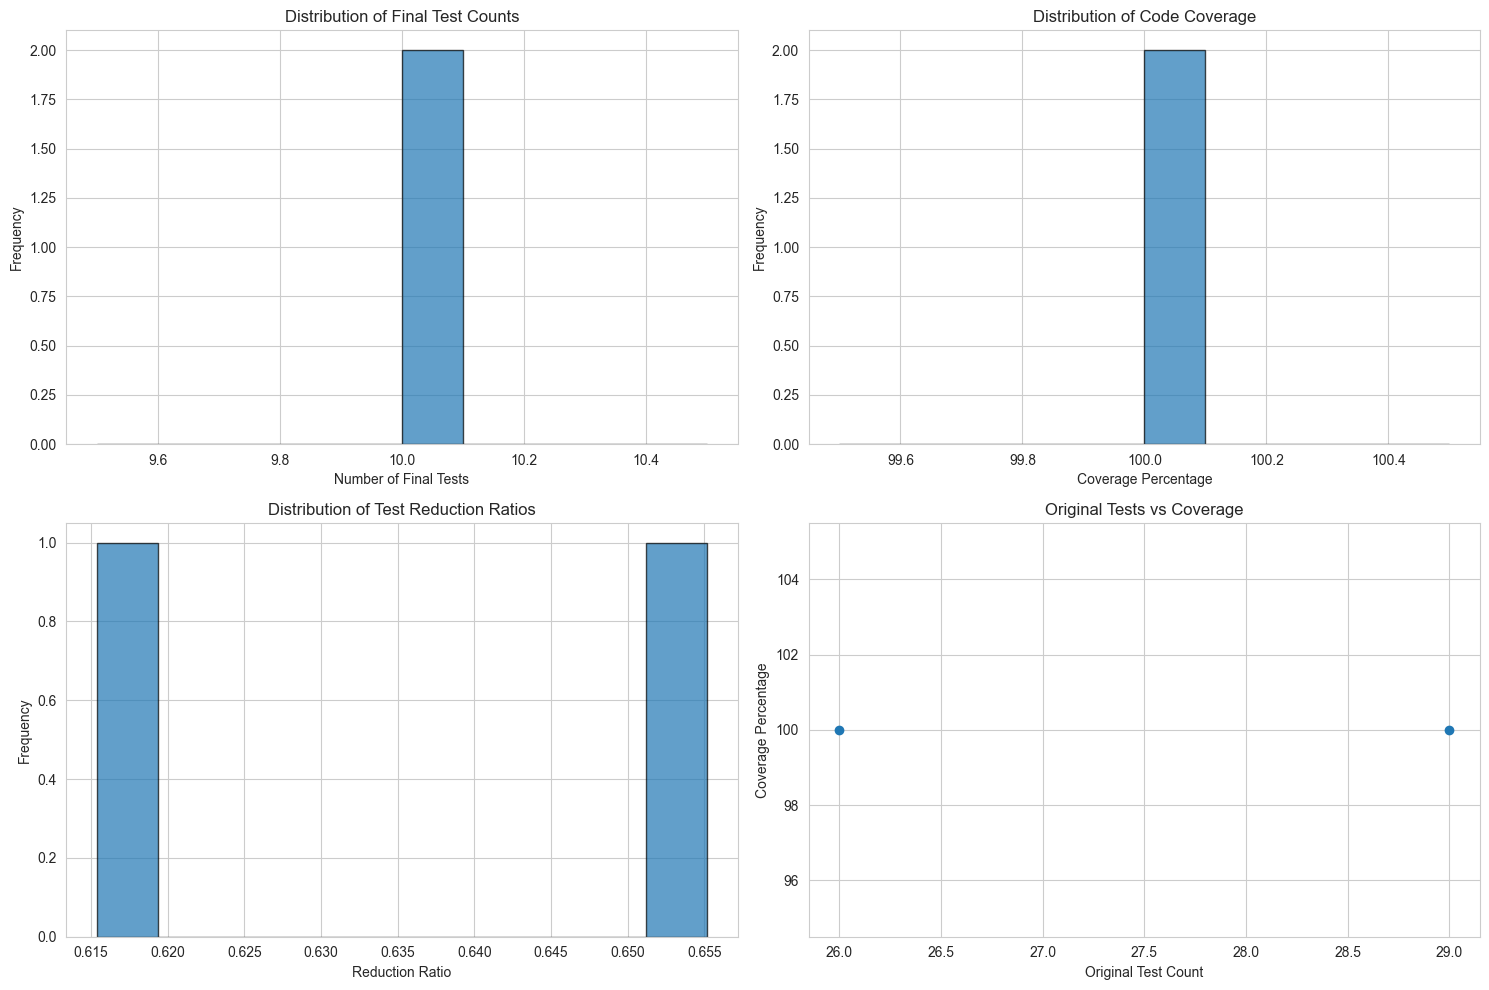

📁 Detailed results saved to batch_evaluation.csv


In [14]:
# Cell 14: Batch Testing and Evaluation (FIXED)
def batch_evaluate_functions(function_list: List[str], output_file: str = "batch_evaluation.csv"):
    """Evaluate multiple functions in batch and generate comparison report"""
    
    print(f"🔄 Starting batch evaluation of {len(function_list)} functions...")
    
    results_data = []
    
    for i, func_code in enumerate(tqdm(function_list, desc="Processing functions")):
        try:
            print(f"\n📝 Processing function {i+1}/{len(function_list)}")
            
            # Run council pipeline
            results = intelligent_council.generate_comprehensive_tests(func_code)
            
            if 'error' in results:
                print(f"❌ Error processing function {i+1}: {results['error']}")
                row_data = {
                    'function_name': f'function_{i+1}',
                    'original_tests': 0,
                    'final_tests': 0,
                    'reduction_ratio': 0,
                    'coverage_percentage': 0,
                    'models_used': 0,
                    'categories_count': 0,
                    'categories': '',
                    'error': results['error'],
                    'success': False
                }
                results_data.append(row_data)
                continue
            
            # Extract key metrics
            stats = results['statistics']
            func_info = results['function_info']
            func_name = func_info['functions'][0]['name'] if func_info['functions'] else f"function_{i+1}"
            
            row_data = {
                'function_name': func_name,
                'original_tests': stats['original_test_count'],
                'final_tests': stats['final_test_count'],
                'reduction_ratio': stats['reduction_ratio'],
                'coverage_percentage': stats['coverage_percentage'],
                'models_used': len(stats['models_used']),
                'categories_count': len(stats['categories_found']),
                'categories': ','.join(stats['categories_found']),
                'synthesizer_model': stats['synthesizer_model'],
                'success': True
            }
            
            results_data.append(row_data)
            print(f"✅ Function {i+1} processed successfully")
            
        except Exception as e:
            print(f"❌ Error processing function {i+1}: {e}")
            results_data.append({
                'function_name': f'function_{i+1}',
                'original_tests': 0,
                'final_tests': 0,
                'reduction_ratio': 0,
                'coverage_percentage': 0,
                'models_used': 0,
                'categories_count': 0,
                'categories': '',
                'error': str(e),
                'success': False
            })
    
    # Create DataFrame and save results
    df = pd.DataFrame(results_data)
    df.to_csv(output_file, index=False)
    
    # Generate summary statistics
    successful_runs = df[df['success'] == True]
    
    if len(successful_runs) > 0:
        print(f"\n📊 Batch Evaluation Summary:")
        print(f"   • Successful runs: {len(successful_runs)}/{len(function_list)}")
        print(f"   • Average original tests: {successful_runs['original_tests'].mean():.1f}")
        print(f"   • Average final tests: {successful_runs['final_tests'].mean():.1f}")
        print(f"   • Average reduction ratio: {successful_runs['reduction_ratio'].mean():.2%}")
        print(f"   • Average coverage: {successful_runs['coverage_percentage'].mean():.1f}%")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Test count distribution
        axes[0, 0].hist(successful_runs['final_tests'], bins=10, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Distribution of Final Test Counts')
        axes[0, 0].set_xlabel('Number of Final Tests')
        axes[0, 0].set_ylabel('Frequency')
        
        # Coverage distribution
        axes[0, 1].hist(successful_runs['coverage_percentage'], bins=10, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Distribution of Code Coverage')
        axes[0, 1].set_xlabel('Coverage Percentage')
        axes[0, 1].set_ylabel('Frequency')
        
        # Reduction ratio distribution
        axes[1, 0].hist(successful_runs['reduction_ratio'], bins=10, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Distribution of Test Reduction Ratios')
        axes[1, 0].set_xlabel('Reduction Ratio')
        axes[1, 0].set_ylabel('Frequency')
        
        # Correlation plot
        axes[1, 1].scatter(successful_runs['original_tests'], successful_runs['coverage_percentage'])
        axes[1, 1].set_title('Original Tests vs Coverage')
        axes[1, 1].set_xlabel('Original Test Count')
        axes[1, 1].set_ylabel('Coverage Percentage')
        
        plt.tight_layout()
        plt.show()
    else:
        print("❌ No successful runs to analyze")
    
    print(f"📁 Detailed results saved to {output_file}")
    return df

# Example batch evaluation with the corrected functions
example_functions = [example_function_1, example_function_2]
batch_results = batch_evaluate_functions(example_functions)